### 나만의 학습/평기용 데이터 세트 구축 방법

1.  가장 먼저 데이터 세트 객체부터 만드는 것 : 어디에서 어떻게 데이터를 불러올지 명시
2.  데이터 로더 : 배치 단위로 데이터 불러오기


```
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        # 데이터 세트에 대한 기본적인 전처리 수행

    def __len__(self):
        # 데이터 세트의 길이 (총 데이터의 개수) 반환

    def __getitem__(self, idx):
        # 데이터 세트에서 하나의 데이터를 가져오기

```




In [10]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

import os
import random
import glob
import xml.etree.ElementTree as elemTree

In [11]:
!pip install captcha

In [12]:
from captcha.image import ImageCaptcha

def generate_images(directory, n_digits):
  # 디렉토리(directory)가 존재하지 않을때
  if not os.path.exists(directory):
    os.makedirs(directory)

  # 이미지 캡처(image captcha) 객체생성
  image = ImageCaptcha()

  #특정한 자릿수 (n_digits)만큼의 모든 정수 생성
  target = (10 ** n_digits) - 1
  for number in range(0, target + 1):
    # 문자열 형태로 변환
    string = str(number).zfill(n_digits)
    # 이미지 캡차 생성
    image.write(string, os.path.join(directory, f"{string}_0.png"))

    if (number + 1) % 1000 == 0:
            print(f"[Log] {number + 1} images have been generated.")

def generate_random_images(directory, n_digits, cnt):
    # 디렉토리(directory)가 존재하지 않을 때
    if not os.path.exists(directory):
        os.makedirs(directory)

    # 이미지 캡차(image captcha) 객체 생성
    image = ImageCaptcha()

    # 개수(cnt)만큼 이미지 캡차 생성
    for i in range(cnt):
        # 특정한 자릿수(n_digits)의 랜덤 정수 생성
        number = random.randint(0, (10 ** n_digits) - 1)
        # 문자열 형태로 변환
        string = str(number).zfill(n_digits)
        # 이미지 캡차 생성
        cur = 0
        path = os.path.join(directory, f"{string}_{cur}.png")
        while os.path.exists(path):
            cur += 1
            path = os.path.join(directory, f"{string}_{cur}.png")
        image.write(string, path)

        if (i + 1) % 1000 == 0:
            print(f"[Log] {i + 1} images have been generated.")

In [13]:
# 학습 데이터 세트 생성
directory = "./train"
n_digits = 4

generate_images(directory, n_digits)

# 이미지 데이터 세트 생성
directory = "./test"
n_digits = 4
cnt = 1000

generate_random_images(directory, n_digits, cnt)

[Log] 1000 images have been generated.
[Log] 2000 images have been generated.
[Log] 3000 images have been generated.
[Log] 4000 images have been generated.
[Log] 5000 images have been generated.
[Log] 6000 images have been generated.
[Log] 7000 images have been generated.
[Log] 8000 images have been generated.
[Log] 9000 images have been generated.
[Log] 10000 images have been generated.
[Log] 1000 images have been generated.


In [17]:
# (1) PyTorch에서는 나만의 데이터 세트를 구축하려면, 데이터 세트 클래스부터 정의
class CustomCaptchaDataset(torch.utils.data.Dataset):
    # 1) __init__(): 이 데이터 세트에서 사용될 정보를 초기화
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        # 전체 이미지의 모든 경로를 다 담아요.
        self.image_path_list = glob.glob(os.path.join(self.directory, "*"))
        # 그 이미지들에 대해서 모든 정답을 다 담아요.
        self.labels = []
        # 하나씩 이미지 경로를 확인하며
        for image_path in self.image_path_list:
            # 정수 데이터 부분만 확인
            label = image_path.split('/')[-1].split('_')[0]
            # 각 숫자(digit)를 리스트에 담기
            label = [int(x) for x in label]
            self.labels.append(label)

    # 2) 데이터 세트의 길이: 이거 왜 필요할까요?
    # batch_size 때문에 쓰이는 것.
    # 예시) 데이터 개수가 10,000개이고, batch_size가 100이면
    # 100번만 수행해야 하기 때문
    # for (inputs, labels) in data_loader:
    #  # 이 코드는 100번만 수행
    def __len__(self):
        return len(self.image_path_list)

    # 3) 실제 데이터를 불러오는 코드
    # 이미지는 보통 PIL -> transforms 적용해서 텐서로 만들어줌
    # 레이블은 보통 그냥 바로 torch.tensor()하면 끝
    # <중요> 출력되는 정보는 기본적으로 PyTorch의 텐서(tensor) 형태가 되어야 함.
    # 앞서 정의했던 경로에서 실제로 1개(단 하나)의 데이터를 불러오는 코드를
    def __getitem__(self, idx):
        image_path = self.image_path_list[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)

        return image, label

In [18]:
def imshow(img, grayscale=False):
    npimg = img.numpy()
    # (높이, 너비, 채널) 형태로 변환
    npimg = np.transpose(npimg, (1, 2, 0))
    # 정규화 해제
    npimg = npimg * [0.5, 0.5, 0.5]
    npimg = npimg + [0.5, 0.5, 0.5]
    if grayscale:
        # 흑백 이미지는 채널 차원 제거
        npimg = np.squeeze(npimg)
        plt.imshow(npimg, cmap="gray")
    else:
        plt.imshow(npimg)
    plt.show()

학습 데이터 개수: 10000


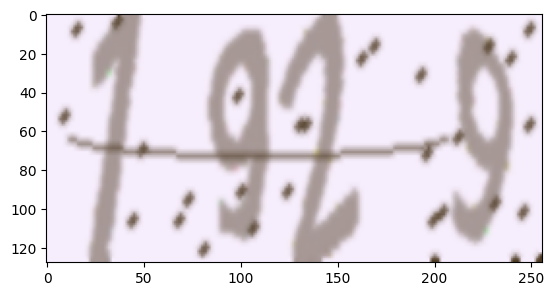

tensor([1, 9, 2, 9])


In [19]:
# PyTorch의 transforms는 "PIL" 객체를 입력으로 받는 게 기본
# 그래서 OpenCV로 불러올 거면, 별도로 코드가 더 추가됨 => 그래서 보통 PIL로 불러옴.
train_transform = transforms.Compose([
    transforms.Resize((128, 256)), # PIL 객체에 대해서 이미지 크기 변경
    transforms.ToTensor(), # 텐서로 변경 => 각 픽셀마다 값이 [0, 1]의 실수
    # R, G, B 채널 각각에 대하여 픽셀의 평균 값을 0, 표준 편차를 1로 만들기 위해
    # 보통 mean, std를 사용.
    # 근데, 이걸 구하기 어려우면, 그냥 픽셀의 평균이 0.5라고 치고
    # 아래와 같은 코드로 정규화를 진행.
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 1. 데이터 세트 객체를 초기화
train_dataset = CustomCaptchaDataset("./train/", transform=train_transform)
# 2. 데이터 로더에 해당 데이터 세트 객체를 넣어줌
# 바로 여기에서 batch_size를 설정
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"학습 데이터 개수: {len(train_dataset)}")
iterator = iter(train_dataloader)
imgs, labels = next(iterator)

# 배치 안에서 첫 번째 데이터 시각화
imshow(imgs[0])
print(labels[0])

In [20]:
for (inputs, labels) in train_dataloader:
    print(inputs.shape) # [batch_size, channel, width, height]
    print(labels.shape) # [batch_size, digits_size]

    break

torch.Size([64, 3, 128, 256])
torch.Size([64, 4])
